# 卷積神經網路(Convolutional Neural Network, CNN)
**CNN主要是對影像做局部的特徵擷取，而每個卷積層檢測的特徵都不同，像是前段的部分負責低階的特徵(線條、顏色等)，後段的負責高階的特徵(眼睛、鼻子等)。CNN做完特徵擷取後，會透過全連接層(Fully Connected Layer)進行分類。**

# CNN 網路架構
**典型的CNN由卷積層(Convolutional Layer)、池化層(Pooling Layer)、扁平層(Flatten Layer)和全連接層(Fully Connected Layer)所組成。**
![alt text](https://i.imgur.com/ap6cgxm.jpg "Title")

### 卷積層(Convolutional Layer)
##### 卷積核(Convolutional kernel, 又稱濾波器，Filter或Kernel)：
卷積層的原理在於透過許多**卷積核**在圖片上滑動，例:一張**4x4的Input**和**3x3的Kernel**，最後會產生**2x2的Output**。Kernel的**大小**及**數量**是可調整的，通常設定為奇數。如果Kernel數量太多也會造成Overfitting，並且卷積層如同全連接層一樣可以加上Bias參數。  
卷積層的輸出通常稱為**特徵圖(Feature map)**，是具有長寬高的3維張量。
##### 填補(Padding)：
根據上述所說的例子，4x4的輸入卻得到2x2的輸出，輸入和輸出的大小並不一致。所以可透過**Padding(或稱Zero-Padding)**在輸入的圖片周圍加上**0**，使輸入和輸出一致。例:一張**4x4的Input**先經由Padding得到**6x6的新Input**，再經過**3x3的Kernel**會得到**4x4的Output**。
##### 步幅(Stride)：
一般的Kernel的移動步幅為**1**，這種卷積又稱為**步進卷積(Strided Convolution)**。例:一張**5x5的Input**和**3x3的Kernel**，Stride設為**2**對輸入進行了兩倍的**下採樣(Subsampled, 縮小影像)**，得到**2x2的Output**。
##### 卷積層輸出尺寸計算：
Padding模式下的卷積層輸出尺寸的計算方式有「Same Padding」和「Valid Padding」。  
**Same Padding：輸入影像會經過Padding，使輸入和輸出大小相同。**  
Output = Input / Strides  
**Valid Padding：輸入原始影像，輸出會小於輸入。**  
Output = (Input - Kernel + 1) / Strides  
**ex.** Input:(4,4,3)、Padding:0、Stride:1、Kernel:(3,3)兩個，所以Output=? Ans:(4-3+1)/1=2，所以Output=(2,2,2)，第三個2代表兩個Kernel。
##### 卷積層參數量計算：
**Parameter = (Channel x Kernel(height) x Kernel(width) + Bias) x kernel(number)**  
Bias: 有為**1**，反之為**0**  
**ex.** 承上，Parameter = ( 3 * 3 * 3 + 0 ) * 2 = 54

### 池化層(Pooling Layer)
池化層(Pooling Layer)常用來進行下採樣的運算，這一層**沒有參數**，只有**Max**或**Mean**的張量運算。如最大池化(Max Pooling)或平均池化(Average Pooling)等。  
**ex.** 有4x4的Input，Max Pooling會去計算2x2區塊的最大值作為輸出，最終產生2x2的Output。  
一般來說，Average Pooling會保留更多**背景資訊**，Max Pooling會保留更多**紋理資訊**。

### 扁平層(Flatten Layer)
扁平層(Flatten Layer)大部分使用在卷積層和全連接層間，負責將輸入的多維特徵張量拉長成一維特徵張量輸出。  
**ex.** 4x4(Input) => 16(Output)

# 多類別分類問題
### Softmax
設計多類別分類問題時，輸出層通常使用Softmax激勵函數，又稱歸一化指數函數。與二元分類的Sigmoid不同，Softmax能夠將每個預測值以機率模型描述，使每個輸出值都介於0 ~ 1間，且總和為"1"。
### Categorical Cross-Entropy
BCE指Sigmoid和CE組合，而CCE則是Softmax和CE組合，所以又稱**Softmax Loss**。

# 實驗：CIFAR-10 影像識別
#### Model-1: Fully Connected Layer、Model-2: Convolutional Layer、Model-3: Model-2 + Image Augmentation

In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import layers

## 一. Prepare dataset

In [2]:
# 查看Tensorflow Datasets
tfds.list_builders()

['abstract_reasoning',
 'aeslc',
 'aflw2k3d',
 'ai2_arc',
 'amazon_us_reviews',
 'anli',
 'arc',
 'bair_robot_pushing_small',
 'beans',
 'big_patent',
 'bigearthnet',
 'billsum',
 'binarized_mnist',
 'binary_alpha_digits',
 'blimp',
 'c4',
 'caltech101',
 'caltech_birds2010',
 'caltech_birds2011',
 'cars196',
 'cassava',
 'cats_vs_dogs',
 'celeb_a',
 'celeb_a_hq',
 'cfq',
 'chexpert',
 'cifar10',
 'cifar100',
 'cifar10_1',
 'cifar10_corrupted',
 'citrus_leaves',
 'cityscapes',
 'civil_comments',
 'clevr',
 'clinc_oos',
 'cmaterdb',
 'cnn_dailymail',
 'coco',
 'coil100',
 'colorectal_histology',
 'colorectal_histology_large',
 'common_voice',
 'cos_e',
 'cosmos_qa',
 'covid19sum',
 'crema_d',
 'curated_breast_imaging_ddsm',
 'cycle_gan',
 'deep_weeds',
 'definite_pronoun_resolution',
 'dementiabank',
 'diabetic_retinopathy_detection',
 'div2k',
 'dmlab',
 'downsampled_imagenet',
 'dsprites',
 'dtd',
 'duke_ultrasound',
 'emnist',
 'eraser_multi_rc',
 'esnli',
 'eurosat',
 'fashion_mnist

In [3]:
# 載入 CIFAR-10資料集
train_split, valid_split = ["train[:90%]", "train[90:]"] # 訓練:驗證 = 9:1
train_data, info = tfds.load("cifar10", split=train_split, with_info=True) # 讀取訓練資料及Data的資訊
valid_data = tfds.load("cifar10", split=valid_split) # 讀取驗證資料
test_data = tfds.load("cifar10", split="test")

In [4]:
info

tfds.core.DatasetInfo(
    name='cifar10',
    version=3.0.2,
    description='The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.',
    homepage='https://www.cs.toronto.edu/~kriz/cifar.html',
    features=FeaturesDict({
        'id': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(32, 32, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=60000,
    splits={
        'test': 10000,
        'train': 50000,
    },
    supervised_keys=('image', 'label'),
    citation="""@TECHREPORT{Krizhevsky09learningmultiple,
        author = {Alex Krizhevsky},
        title = {Learning multiple layers of features from tiny images},
        institution = {},
        year = {2009}
    }""",
    redistribution_info=,
)

In [5]:
# 設定Label標籤
label_dict = dict(enumerate(info.features['label'].names))
label_dict

{0: 'airplane',
 1: 'automobile',
 2: 'bird',
 3: 'cat',
 4: 'deer',
 5: 'dog',
 6: 'frog',
 7: 'horse',
 8: 'ship',
 9: 'truck'}

In [6]:
# 查看各類別數量
train_dict = {}
for data in train_data:
    label = data['label'].numpy()
    train_dict[label] = train_dict.setdefault(label, 0) + 1
train_dict

{7: 4500,
 8: 4456,
 4: 4497,
 6: 4505,
 5: 4503,
 2: 4522,
 9: 4453,
 3: 4526,
 0: 4530,
 1: 4508}

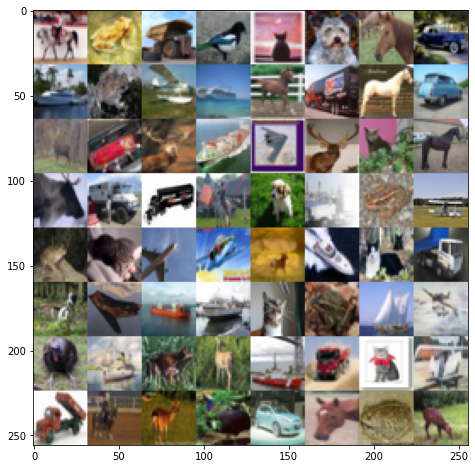

In [7]:
# 顯示部分圖片
# 建立影像陣列
output = np.zeros((32 * 8, 32 * 8, 3), dtype=np.uint8)
row = 0
# 從 train_data 取出8筆資料，共取8次，總共64筆
for data in train_data.batch(8).take(8):
    # 將取得的8筆資料堆疊起來，放入影像陣列第N列中
    output[:, row*32:(row+1)*32] = np.vstack(data['image'].numpy())
    row += 1
# 視窗大小
plt.figure(figsize=(8, 8))
# 顯示
plt.imshow(output)

### 資料預處理(Data Preprocessing)
#### 影像資料：每個像素除以255，使其介於0 ~ 1間。
#### 標籤資料：做One-hot Encoding

In [8]:
def parse_fn(dataset):
    # 影像標準化
    x = tf.cast(dataset['image'], tf.float32) / 255.
    # 標籤轉One-hot Encoding
    y = tf.one_hot(dataset['label'], 10)
    return x,y

In [9]:
AUTOTUNE = tf.data.experimental.AUTOTUNE # 自行調整模式
batch_size = 128 # 批次大小
train_num = int(info.splits['train'].num_examples / 10) * 9 # 訓練資料數量

In [10]:
# 打散資料
train_data = train_data.shuffle(train_num)
# 載入預處理 parse_fn()，CPU數量為自動調整模式
train_data = train_data.map(map_func=parse_fn, num_parallel_calls=AUTOTUNE)
# 設定批次大小，並將 prefetch 模式打開(暫存空間為自動調整模式)
train_data = train_data.batch(batch_size).prefetch(buffer_size=AUTOTUNE)

valid_data = valid_data.map(map_func=parse_fn, num_parallel_calls=AUTOTUNE)
valid_data = valid_data.batch(batch_size).prefetch(buffer_size=AUTOTUNE)
test_data = test_data.map(map_func=parse_fn, num_parallel_calls=AUTOTUNE)
test_data = test_data.batch(batch_size).prefetch(buffer_size=AUTOTUNE)

## 二. 訓練Model-1和Model-2

### Model-1 全連結層網路

In [11]:
model_1 = tf.keras.Sequential([
    layers.Flatten(input_shape=(32, 32, 3)),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(10, activation='softmax')
])
model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 3072)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               393344    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               33024     
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               131584    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0

In [12]:
model_dir = './models/Ch4'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

In [13]:
# 設定Optimizer、Loss Function、Metrics Function
model_1.compile(keras.optimizers.Adam(),
                loss=keras.losses.CategoricalCrossentropy(),
                metrics=[keras.metrics.CategoricalAccuracy()]
                )

# 設定回調函數
log_dir = os.path.join('./models/Ch4', 'model-1')
model_cbk = keras.callbacks.TensorBoard(log_dir=log_dir)
model_mckp = keras.callbacks.ModelCheckpoint(model_dir + '/Best-model-1.h5',
                                             monitor='val_categorical_accuracy',
                                             save_best_only=True,
                                             mode='max'
                                            )
history_1 = model_1.fit(train_data,
                        epochs=100,
                        validation_data=valid_data,
                        callbacks=[model_cbk, model_mckp]
                       )

Epoch 1/100
  1/352 [..............................] - ETA: 0s - loss: 2.4438 - categorical_accuracy: 0.0938WARNING:tensorflow:From C:\Users\a7032\AI_Deep_Learing\Tensorflow2\tf2\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.


Instructions for updating:
use `tf.profiler.experimental.stop` instead.


352/352 [==============================] - 3s 8ms/step - loss: 2.1952 - categorical_accuracy: 0.1523 - val_loss: 2.1085 - val_categorical_accuracy: 0.1893
Epoch 2/100
352/352 [==============================] - 2s 5ms/step - loss: 2.1299 - categorical_accuracy: 0.1742 - val_loss: 2.0696 - val_categorical_accuracy: 0.1961
Epoch 3/100
352/352 [==============================] - 2s 5ms/step - loss: 2.1098 - categorical_accuracy: 0.1857 - val_loss: 2.0420 - val_categorical_accuracy: 0.2267
Epoch 4/100
352/352 [==============================] - 2s 5ms/step - loss: 2.1003 - categorical_accuracy: 0.1879 - val_loss: 2.0414 - val_categorical_accuracy: 0.2270
Epoch 5/100
352/352 [==============================] - 2s 5ms/step - loss: 2.0813 - categorical_accuracy: 0.2010 - val_loss: 2.0355 - val_categorical_accuracy: 0.2206
Epoch 6/100
352/352 [==============================] - 2s 5ms/step - loss: 2.0792 - categorical_accuracy: 0.1980 - val_loss: 1.9972 - val_categorical_accuracy: 0.2393
Epoch 7/10

352/352 [==============================] - 2s 5ms/step - loss: 1.9663 - categorical_accuracy: 0.2486 - val_loss: 1.9845 - val_categorical_accuracy: 0.2513
Epoch 50/100
352/352 [==============================] - 2s 5ms/step - loss: 1.9698 - categorical_accuracy: 0.2470 - val_loss: 1.9632 - val_categorical_accuracy: 0.2510
Epoch 51/100
352/352 [==============================] - 2s 5ms/step - loss: 1.9666 - categorical_accuracy: 0.2473 - val_loss: 1.9843 - val_categorical_accuracy: 0.2460
Epoch 52/100
352/352 [==============================] - 2s 5ms/step - loss: 1.9645 - categorical_accuracy: 0.2484 - val_loss: 1.9538 - val_categorical_accuracy: 0.2659
Epoch 53/100
352/352 [==============================] - 2s 5ms/step - loss: 1.9662 - categorical_accuracy: 0.2500 - val_loss: 1.9628 - val_categorical_accuracy: 0.2625
Epoch 54/100
352/352 [==============================] - 2s 5ms/step - loss: 1.9610 - categorical_accuracy: 0.2521 - val_loss: 1.9484 - val_categorical_accuracy: 0.2523
Epoch

Epoch 98/100
352/352 [==============================] - 2s 5ms/step - loss: 1.9600 - categorical_accuracy: 0.2558 - val_loss: 1.9749 - val_categorical_accuracy: 0.2513
Epoch 99/100
352/352 [==============================] - 2s 5ms/step - loss: 1.9699 - categorical_accuracy: 0.2506 - val_loss: 1.9856 - val_categorical_accuracy: 0.2376
Epoch 100/100
352/352 [==============================] - 2s 5ms/step - loss: 1.9557 - categorical_accuracy: 0.2527 - val_loss: 1.9604 - val_categorical_accuracy: 0.2464


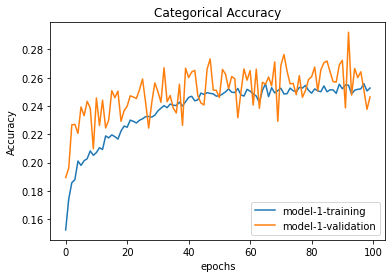

In [14]:
plt.plot(history_1.history['categorical_accuracy'], label='model-1-training')
plt.plot(history_1.history['val_categorical_accuracy'], label='model-1-validation')
plt.title('Categorical Accuracy')
plt.xlabel('epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [18]:
model_1.load_weights('./models/Ch4/Best-model-1.h5')
loss_1, acc_1 = model_1.evaluate(test_data)
print("Model-1：{}%".format(acc_1))

79/79 [==============================] - 0s 2ms/step - loss: 1.9120 - categorical_accuracy: 0.2880
Model-1：0.2879999876022339%


### Model-2 卷積神經網路

In [20]:
model_2 = tf.keras.Sequential([
    layers.Conv2D(64, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    layers.MaxPool2D(),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(10, activation='softmax')
])
model_2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 30, 30, 64)        1792      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 13, 13, 128)       73856     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 11, 11, 256)       295168    
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 9, 9, 128)         295040    
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 7, 7, 64)          73792     
_________________________________________________________________
flatten_2 (Flatten)          (None, 3136)             

In [21]:
# 設定Optimizer、Loss Function、Metrics Function
model_2.compile(keras.optimizers.Adam(),
                loss=keras.losses.CategoricalCrossentropy(),
                metrics=[keras.metrics.CategoricalAccuracy()]
                )

# 設定回調函數
log_dir = os.path.join('./models/Ch4', 'model-2')
model_cbk = keras.callbacks.TensorBoard(log_dir=log_dir)
model_mckp = keras.callbacks.ModelCheckpoint(model_dir + '/Best-model-2.h5',
                                             monitor='val_categorical_accuracy',
                                             save_best_only=True,
                                             mode='max'
                                            )
history_2 = model_2.fit(train_data,
                        epochs=100,
                        validation_data=valid_data,
                        callbacks=[model_cbk, model_mckp]
                       )

Epoch 1/100
  2/352 [..............................] - ETA: 14s - loss: 2.3029 - categorical_accuracy: 0.0859WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0090s vs `on_train_batch_end` time: 0.0756s). Check your callbacks.


352/352 [==============================] - 9s 25ms/step - loss: 1.9443 - categorical_accuracy: 0.2635 - val_loss: 1.5483 - val_categorical_accuracy: 0.4403
Epoch 2/100
352/352 [==============================] - 8s 24ms/step - loss: 1.5620 - categorical_accuracy: 0.4270 - val_loss: 1.2938 - val_categorical_accuracy: 0.5305
Epoch 3/100
352/352 [==============================] - 8s 24ms/step - loss: 1.3949 - categorical_accuracy: 0.5015 - val_loss: 1.1433 - val_categorical_accuracy: 0.5949
Epoch 4/100
352/352 [==============================] - 8s 24ms/step - loss: 1.2693 - categorical_accuracy: 0.5546 - val_loss: 1.0586 - val_categorical_accuracy: 0.6162
Epoch 5/100
352/352 [==============================] - 9s 24ms/step - loss: 1.1511 - categorical_accuracy: 0.5966 - val_loss: 0.9261 - val_categorical_accuracy: 0.6693
Epoch 6/100
352/352 [==============================] - 8s 24ms/step - loss: 1.0725 - categorical_accuracy: 0.6247 - val_loss: 0.9546 - val_categorical_accuracy: 0.6596
Epoc

352/352 [==============================] - 9s 27ms/step - loss: 0.1321 - categorical_accuracy: 0.9562 - val_loss: 0.2067 - val_categorical_accuracy: 0.9656
Epoch 50/100
352/352 [==============================] - 9s 26ms/step - loss: 0.1271 - categorical_accuracy: 0.9588 - val_loss: 0.2193 - val_categorical_accuracy: 0.9577
Epoch 51/100
352/352 [==============================] - 10s 27ms/step - loss: 0.1356 - categorical_accuracy: 0.9560 - val_loss: 0.2261 - val_categorical_accuracy: 0.9557
Epoch 52/100
352/352 [==============================] - 10s 28ms/step - loss: 0.1219 - categorical_accuracy: 0.9605 - val_loss: 0.2015 - val_categorical_accuracy: 0.9652
Epoch 53/100
352/352 [==============================] - 10s 27ms/step - loss: 0.1171 - categorical_accuracy: 0.9620 - val_loss: 0.2227 - val_categorical_accuracy: 0.9600
Epoch 54/100
352/352 [==============================] - 10s 27ms/step - loss: 0.1185 - categorical_accuracy: 0.9606 - val_loss: 0.2052 - val_categorical_accuracy: 0.

352/352 [==============================] - 8s 24ms/step - loss: 0.0692 - categorical_accuracy: 0.9786 - val_loss: 0.2463 - val_categorical_accuracy: 0.9684
Epoch 98/100
352/352 [==============================] - 8s 24ms/step - loss: 0.0682 - categorical_accuracy: 0.9795 - val_loss: 0.2428 - val_categorical_accuracy: 0.9643
Epoch 99/100
352/352 [==============================] - 8s 24ms/step - loss: 0.0555 - categorical_accuracy: 0.9816 - val_loss: 0.2445 - val_categorical_accuracy: 0.9697
Epoch 100/100
352/352 [==============================] - 8s 24ms/step - loss: 0.0828 - categorical_accuracy: 0.9754 - val_loss: 0.2601 - val_categorical_accuracy: 0.9644


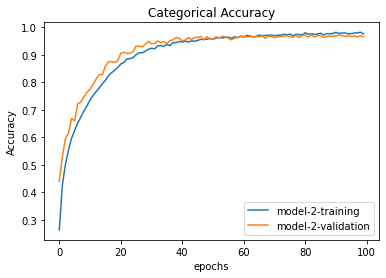

In [22]:
plt.plot(history_2.history['categorical_accuracy'], label='model-2-training')
plt.plot(history_2.history['val_categorical_accuracy'], label='model-2-validation')
plt.title('Categorical Accuracy')
plt.xlabel('epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [30]:
model_2.load_weights('./models/Ch4/Best-model-2.h5')
loss_2, acc_2 = model_2.evaluate(test_data)
print("Model-2：{}%".format(acc_2))

79/79 [==============================] - 1s 7ms/step - loss: 2.0992 - categorical_accuracy: 0.7539
Model-2：0.7538999915122986%


### Model-3 卷積神經網路加資料增強
#### 資料增強

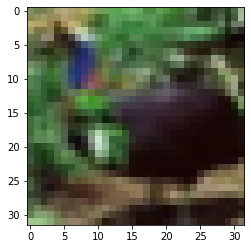

In [29]:
x = 3
y = 7
# 隨機讀取剛才64張中的1張
image_test = output[y*32:(y+1)*32, x*32:(x+1)*32:]
plt.imshow(image_test)

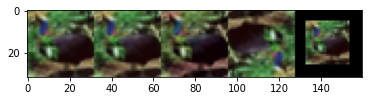

In [45]:
# 水平翻轉
def flip(x):
    x = tf.image.random_flip_left_right(x)
    return x

# 顏色轉換
def color(x):
    x = tf.image.random_hue(x, 0.08) # 色調
    x = tf.image.random_saturation(x, 0.6, 1.6) # 飽和度
    x = tf.image.random_brightness(x, 0.05) # 亮度
    x = tf.image.random_contrast(x, 0.7, 1.3) # 對比度
    return x

# 影像旋轉
def rotate(x):
    # 隨機旋轉 n 次，minval和maxval設定 n 的範圍，每次旋轉90度
    x = tf.image.rot90(x, tf.random.uniform(shape=[], minval=1, maxval=4, dtype=tf.int32))
    return x

# 影像縮放
def zoom(x, scale_min=0.6, scale_max=1.4):
    h, w, c = x.shape
    # 隨機縮放比例
    scale = tf.random.uniform([], scale_min, scale_max)
    sh = h * scale # 縮放後的影像高度
    sw = w * scale # 縮放後的影像寬度
    # 縮放影像
    x = tf.image.resize(x, (sh, sw))
    # 影像縮減或填補
    x = tf.image.resize_with_crop_or_pad(x, h ,w)
    return x

image_2 = flip(image_test)
image_3 = color(image_test)
image_4 = rotate(image_test)
 # 由於縮放完後會變成浮點數，所以要轉回來
image_5 = zoom(image_test)
image_5 = tf.cast(image_5, dtype=tf.uint8)

# 合併
image = np.hstack((image_test, image_2, image_3, image_4, image_5))
plt.imshow(image)

#### 資料集設定

In [46]:
# 重新載入一次資料集
train_data = tfds.load("cifar10", split=train_split)
# 資料預處理
def parse_aug_fn(dataset):
    # 影像標準化
    x = tf.cast(dataset['image'], tf.float32) / 255.
    # 資料增強
    x = flip(x) # 水平翻轉
    x = tf.cond(tf.random.uniform([], 0, 1) > 0.5, lambda: color(x), lambda:x) # 50%機率顏色轉換
    x = tf.cond(tf.random.uniform([], 0, 1) > 0.75, lambda: rotate(x), lambda:x) # 25%機率影像旋轉
    x = tf.cond(tf.random.uniform([], 0, 1) > 0.5, lambda: zoom(x), lambda:x) # 50%機率影像縮放
    # 標籤轉One-hot Encoding
    y = tf.one_hot(dataset['label'], 10)
    return x,y

In [47]:
# 打散資料
train_data = train_data.shuffle(train_num)
# 載入預處理 parse_fn()，CPU數量為自動調整模式
train_data = train_data.map(map_func=parse_aug_fn, num_parallel_calls=AUTOTUNE)
# 設定批次大小，並將 prefetch 模式打開(暫存空間為自動調整模式)
train_data = train_data.batch(batch_size).prefetch(buffer_size=AUTOTUNE)

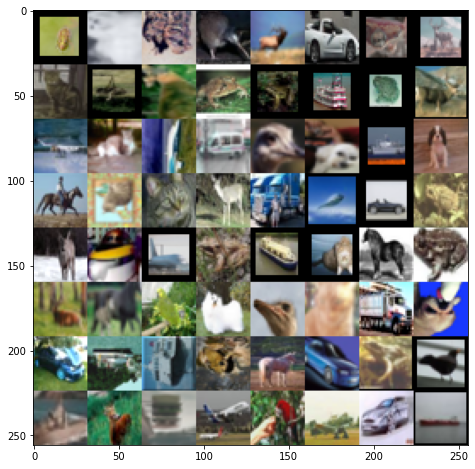

In [49]:
# 查看結果
for images, labels in train_data.take(1):
    images = images.numpy()
# 建立影像陣列
output = np.zeros((32 * 8, 32 * 8, 3))
# 將64筆資料分別放入顯示影像的陣列
for i in range(8):
    for j in range(8):
        output[i*32:(i+1)*32, j*32:(j+1)*32, :] = images[i*8+j]
plt.figure(figsize=(8, 8))
# 顯示影像
plt.imshow(output)

#### Model-3

In [50]:
model_3 = tf.keras.Sequential([
    layers.Conv2D(64, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    layers.MaxPool2D(),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(10, activation='softmax')
])
model_3.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 30, 30, 64)        1792      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 13, 13, 128)       73856     
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 11, 11, 256)       295168    
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 9, 9, 128)         295040    
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 7, 7, 64)          73792     
_________________________________________________________________
flatten_3 (Flatten)          (None, 3136)             

In [51]:
# 設定Optimizer、Loss Function、Metrics Function
model_3.compile(keras.optimizers.Adam(),
                loss=keras.losses.CategoricalCrossentropy(),
                metrics=[keras.metrics.CategoricalAccuracy()]
                )

# 設定回調函數
log_dir = os.path.join('./models/Ch4', 'model-3')
model_cbk = keras.callbacks.TensorBoard(log_dir=log_dir)
model_mckp = keras.callbacks.ModelCheckpoint(model_dir + '/Best-model-3.h5',
                                             monitor='val_categorical_accuracy',
                                             save_best_only=True,
                                             mode='max'
                                            )
history_3 = model_3.fit(train_data,
                        epochs=100,
                        validation_data=valid_data,
                        callbacks=[model_cbk, model_mckp]
                       )

Epoch 1/100
  2/352 [..............................] - ETA: 19s - loss: 2.3092 - categorical_accuracy: 0.0547WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0105s vs `on_train_batch_end` time: 0.0901s). Check your callbacks.


352/352 [==============================] - 9s 25ms/step - loss: 2.0927 - categorical_accuracy: 0.2164 - val_loss: 1.8056 - val_categorical_accuracy: 0.3737
Epoch 2/100
352/352 [==============================] - 9s 25ms/step - loss: 1.8795 - categorical_accuracy: 0.3071 - val_loss: 1.5996 - val_categorical_accuracy: 0.4246
Epoch 3/100
352/352 [==============================] - 9s 24ms/step - loss: 1.7686 - categorical_accuracy: 0.3515 - val_loss: 1.4682 - val_categorical_accuracy: 0.4679
Epoch 4/100
352/352 [==============================] - 9s 24ms/step - loss: 1.6814 - categorical_accuracy: 0.3871 - val_loss: 1.3950 - val_categorical_accuracy: 0.4878
Epoch 5/100
352/352 [==============================] - 9s 25ms/step - loss: 1.6138 - categorical_accuracy: 0.4152 - val_loss: 1.2673 - val_categorical_accuracy: 0.5501
Epoch 6/100
352/352 [==============================] - 9s 24ms/step - loss: 1.5494 - categorical_accuracy: 0.4468 - val_loss: 1.2328 - val_categorical_accuracy: 0.5551
Epoc

352/352 [==============================] - 8s 24ms/step - loss: 0.8562 - categorical_accuracy: 0.7113 - val_loss: 0.4694 - val_categorical_accuracy: 0.8362
Epoch 50/100
352/352 [==============================] - 8s 24ms/step - loss: 0.8479 - categorical_accuracy: 0.7155 - val_loss: 0.4777 - val_categorical_accuracy: 0.8380
Epoch 51/100
352/352 [==============================] - 8s 24ms/step - loss: 0.8404 - categorical_accuracy: 0.7157 - val_loss: 0.4706 - val_categorical_accuracy: 0.8399
Epoch 52/100
352/352 [==============================] - 8s 24ms/step - loss: 0.8401 - categorical_accuracy: 0.7174 - val_loss: 0.4562 - val_categorical_accuracy: 0.8414
Epoch 53/100
352/352 [==============================] - 9s 24ms/step - loss: 0.8453 - categorical_accuracy: 0.7149 - val_loss: 0.4445 - val_categorical_accuracy: 0.8493
Epoch 54/100
352/352 [==============================] - 8s 24ms/step - loss: 0.8438 - categorical_accuracy: 0.7173 - val_loss: 0.4817 - val_categorical_accuracy: 0.8383

352/352 [==============================] - 8s 24ms/step - loss: 0.6934 - categorical_accuracy: 0.7712 - val_loss: 0.3482 - val_categorical_accuracy: 0.8826
Epoch 98/100
352/352 [==============================] - 9s 24ms/step - loss: 0.6923 - categorical_accuracy: 0.7696 - val_loss: 0.2974 - val_categorical_accuracy: 0.8993
Epoch 99/100
352/352 [==============================] - 9s 26ms/step - loss: 0.7052 - categorical_accuracy: 0.7676 - val_loss: 0.3165 - val_categorical_accuracy: 0.8959
Epoch 100/100
352/352 [==============================] - 9s 25ms/step - loss: 0.6797 - categorical_accuracy: 0.7756 - val_loss: 0.3095 - val_categorical_accuracy: 0.8992


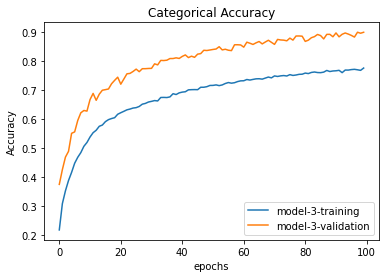

In [52]:
plt.plot(history_3.history['categorical_accuracy'], label='model-3-training')
plt.plot(history_3.history['val_categorical_accuracy'], label='model-3-validation')
plt.title('Categorical Accuracy')
plt.xlabel('epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [53]:
model_3.load_weights('./models/Ch4/Best-model-3.h5')
loss_3, acc_3 = model_3.evaluate(test_data)
print("Model-3：{}%".format(acc_3))

79/79 [==============================] - 0s 6ms/step - loss: 0.5850 - categorical_accuracy: 0.8152
Model-3：0.8151999711990356%


In [55]:
loss = [loss_1, loss_2, loss_3]
acc = [acc_1, acc_2, acc_3]
dict = {"Accuracy":acc, "Loss":loss}
pd.DataFrame(dict)

,Accuracy,Loss
0,0.2880,1.911977
1,0.7539,2.099179
2,0.8152,0.584999


In [56]:
%load_ext tensorboard
%tensorboard --logdir models/Ch4